<a href="https://colab.research.google.com/github/DmitryKutsev/ml_hw/blob/master/hw7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#https://github.com/mannefedov/hse_ml_m1/blob/master/7_cnn/cnn.ipynb
#7
# https://docs.google.com/forms/d/e/1FAIpQLSee0e7Tis3EoPnxGqyb_vHuR-u9Dz2M85ajMd-m9uNX1bsepQ/viewform

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/My Drive/data.zip'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Archive:  /content/drive/My Drive/data.zip
  inflating: avito_data.csv          
  inflating: quora.csv               
  inflating: __MACOSX/._quora.csv    


In [2]:
!pip install pandas scikit-learn gensim matplotlib

In [0]:
import tensorflow as tf

In [0]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    string = ''.join(tokens)
    symbols = [i for i in string if i != " "]
    return symbols

In [0]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
quora = pd.read_csv('quora.csv')

In [8]:
quora

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [0]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [10]:
vocab.most_common(5)

[('e', 8363288),
 ('a', 6388387),
 ('t', 6225943),
 ('o', 6026222),
 ('i', 5826579)]

In [0]:
filtered_vocab = set()

for word in vocab:
    #if vocab[word] > 5:
    filtered_vocab.add(word)

In [0]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [0]:
id2word = {i:word for word, i in word2id.items()}

In [0]:
X = []

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)
#X[:1]

In [0]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])
MEAN_LEN = int(MEAN_LEN)

In [0]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MEAN_LEN)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [0]:
#начну с капипаста куска кода с начала лекции
inputs = tf.keras.layers.Input(shape=(MEAN_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=10)(inputs, )
conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
concat = tf.keras.layers.Flatten()(conv2)
dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [38]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1500,
         epochs=5)

Epoch 1/5
828/828 [==============================] - 7s 8ms/step - loss: 0.2148 - f1: 3.0146e-04 - val_loss: 0.1976 - val_f1: 0.0000e+00
Epoch 2/5
828/828 [==============================] - 6s 7ms/step - loss: 0.1924 - f1: 0.0277 - val_loss: 0.1905 - val_f1: 0.1017
Epoch 3/5
828/828 [==============================] - 6s 7ms/step - loss: 0.1841 - f1: 0.0962 - val_loss: 0.1814 - val_f1: 0.1487
Epoch 4/5
828/828 [==============================] - 6s 7ms/step - loss: 0.1788 - f1: 0.1511 - val_loss: 0.1790 - val_f1: 0.1297
Epoch 5/5
828/828 [==============================] - 6s 7ms/step - loss: 0.1753 - f1: 0.1859 - val_loss: 0.1752 - val_f1: 0.1746


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


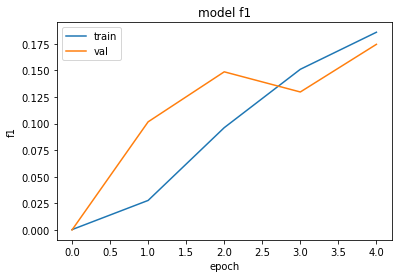

In [39]:
print(model.history.history.keys())

plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
#добавил padding слоев с разными параметрами, и несколько сверточных
inputs = tf.keras.layers.Input(shape=(MEAN_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []


pad1 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad1)

pad2 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(conv1)

conv2 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad2)



pad3 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv3 = tf.keras.layers.Conv1D(kernel_size=7, filters=32, strides=1)(pad3)

pad4 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [3,3], [0, 0]], 
                                               mode='REFLECT'))(conv3)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad4)



concat = tf.keras.layers.concatenate([conv2, conv4])

conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [65]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1500,
         epochs=5)

Epoch 1/5
828/828 [==============================] - 23s 28ms/step - loss: 0.2508 - f1: 0.0012 - val_loss: 0.1938 - val_f1: 0.0115
Epoch 2/5
828/828 [==============================] - 23s 28ms/step - loss: 0.1875 - f1: 0.1205 - val_loss: 0.1809 - val_f1: 0.2439
Epoch 3/5
828/828 [==============================] - 23s 28ms/step - loss: 0.1775 - f1: 0.2197 - val_loss: 0.1794 - val_f1: 0.3276
Epoch 4/5
828/828 [==============================] - 23s 28ms/step - loss: 0.1733 - f1: 0.2500 - val_loss: 0.1810 - val_f1: 0.3589
Epoch 5/5
828/828 [==============================] - 23s 28ms/step - loss: 0.1706 - f1: 0.2665 - val_loss: 0.1743 - val_f1: 0.2159


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


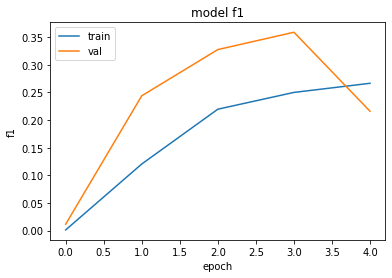

In [66]:
#вроде даже растет где-то
print(model.history.history.keys())

plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
# и теперь к этому еще pooling и поменяю kernel_size
inputs = tf.keras.layers.Input(shape=(MEAN_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []


pad1 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv1 = tf.keras.layers.Conv1D(kernel_size=7, filters=32, strides=1)(pad1)
pool1 = tf.keras.layers.AveragePooling1D()(conv1)
pad2 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [3,3], [0, 0]], 
                                               mode='REFLECT'))(pool1)

conv2 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad2)


pad3 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv3 = tf.keras.layers.Conv1D(kernel_size=7, filters=32, strides=1)(pad3)
pool2 = tf.keras.layers.AveragePooling1D()(conv3)

pad4 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [3,3], [0, 0]], 
                                               mode='REFLECT'))(pool2)

conv4 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad4)



concat = tf.keras.layers.concatenate([conv2, conv4])

conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [111]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
621/621 [==============================] - 22s 36ms/step - loss: 0.2823 - f1: 2.8961e-04 - val_loss: 0.2106 - val_f1: 0.0000e+00
Epoch 2/5
621/621 [==============================] - 22s 35ms/step - loss: 0.2089 - f1: 2.5560e-05 - val_loss: 0.2077 - val_f1: 0.0000e+00
Epoch 3/5
621/621 [==============================] - 22s 35ms/step - loss: 0.2002 - f1: 0.0152 - val_loss: 0.1942 - val_f1: 0.0593
Epoch 4/5
621/621 [==============================] - 22s 35ms/step - loss: 0.1900 - f1: 0.1108 - val_loss: 0.1883 - val_f1: 0.1065
Epoch 5/5
621/621 [==============================] - 22s 35ms/step - loss: 0.1848 - f1: 0.1614 - val_loss: 0.1848 - val_f1: 0.1363


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


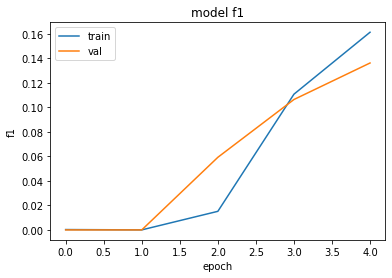

In [112]:
print(model.history.history.keys())

plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
#стало хуже, попробую добавить слоев 
inputs = tf.keras.layers.Input(shape=(MEAN_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []


pad1 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad1)
pool1 = tf.keras.layers.AveragePooling1D()(conv1)
pad2 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(pool1)

conv2 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad2)


pad3 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(pad3)
pool2 = tf.keras.layers.AveragePooling1D()(conv3)

pad4 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(pool2)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad4)


pad5 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv5 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad5)
pool5 = tf.keras.layers.AveragePooling1D()(conv5)
pad6 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(pool5)

conv6 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad6)



concat1 = tf.keras.layers.concatenate([conv2, conv4])
concat = tf.keras.layers.concatenate([concat1, conv6])


conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [97]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
621/621 [==============================] - 24s 38ms/step - loss: 0.3009 - f1: 2.0499e-04 - val_loss: 0.2095 - val_f1: 0.0000e+00
Epoch 2/5
621/621 [==============================] - 24s 38ms/step - loss: 0.2073 - f1: 0.0011 - val_loss: 0.2012 - val_f1: 9.5316e-04
Epoch 3/5
621/621 [==============================] - 24s 38ms/step - loss: 0.1976 - f1: 0.0163 - val_loss: 0.1921 - val_f1: 0.0523
Epoch 4/5
621/621 [==============================] - 24s 38ms/step - loss: 0.1897 - f1: 0.1000 - val_loss: 0.1871 - val_f1: 0.1811
Epoch 5/5
621/621 [==============================] - 23s 38ms/step - loss: 0.1848 - f1: 0.1539 - val_loss: 0.1836 - val_f1: 0.1885


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


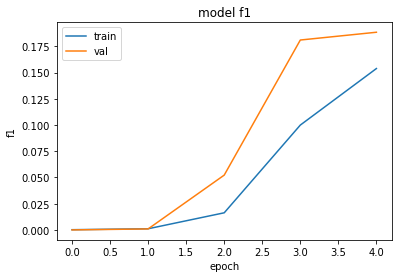

In [98]:
print(model.history.history.keys())

plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [99]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

Epoch 1/10
621/621 [==============================] - 23s 38ms/step - loss: 0.1813 - f1: 0.1828 - val_loss: 0.1802 - val_f1: 0.2097
Epoch 2/10
621/621 [==============================] - 23s 38ms/step - loss: 0.1795 - f1: 0.1981 - val_loss: 0.1815 - val_f1: 0.2412
Epoch 3/10
621/621 [==============================] - 23s 38ms/step - loss: 0.1777 - f1: 0.2114 - val_loss: 0.1782 - val_f1: 0.1956
Epoch 4/10
621/621 [==============================] - 24s 38ms/step - loss: 0.1766 - f1: 0.2224 - val_loss: 0.1764 - val_f1: 0.2242
Epoch 5/10
621/621 [==============================] - 23s 38ms/step - loss: 0.1753 - f1: 0.2318 - val_loss: 0.1759 - val_f1: 0.2188
Epoch 6/10
621/621 [==============================] - 23s 38ms/step - loss: 0.1744 - f1: 0.2399 - val_loss: 0.1765 - val_f1: 0.2492
Epoch 7/10
621/621 [==============================] - 24s 38ms/step - loss: 0.1737 - f1: 0.2436 - val_loss: 0.1757 - val_f1: 0.2649
Epoch 8/10
621/621 [==============================] - 23s 38ms/step - loss: 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


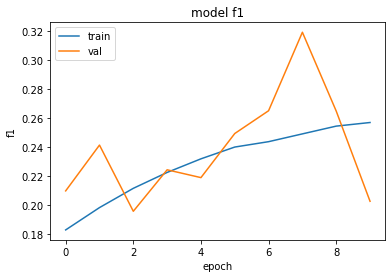

In [100]:
print(model.history.history.keys())

plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
#вроде что-то иногда растет, попробую добавить дропаут и коллбэки
inputs = tf.keras.layers.Input(shape=(MEAN_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []


pad1 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad1)
pool1 = tf.keras.layers.AveragePooling1D()(conv1)
pad2 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(pool1)

conv2 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad2)


drop1 = tf.keras.layers.Dropout(0.2)(embeddings)
pad3 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(pad3)
pool2 = tf.keras.layers.AveragePooling1D()(conv3)

pad4 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(pool2)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad4)


pad5 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv5 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad5)
pool5 = tf.keras.layers.AveragePooling1D()(conv5)
pad6 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(pool5)

conv6 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad6)
drop2 = tf.keras.layers.Dropout(0.2)(conv6)


concat1 = tf.keras.layers.concatenate([conv2, conv4])
concat = tf.keras.layers.concatenate([concat1, drop2])


conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [0]:

checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights',  
                                                monitor='val_f1',
                                                verbose=1, 
                                                save_weights_only=True,
                                                save_best_only=True,
                                                mode='max', 
                                                save_freq='epoch' 
                                               )


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01,
                                              patience=3, 
                                              verbose=1, 
                                              mode='max',
                                              )

In [103]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10,
         callbacks=[checkpoint, early_stop])

Epoch 1/10
621/621 [==============================] - ETA: 0s - loss: 0.2987 - f1: 1.9797e-04
Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to model.weights
621/621 [==============================] - 24s 38ms/step - loss: 0.2987 - f1: 1.9797e-04 - val_loss: 0.2109 - val_f1: 0.0000e+00
Epoch 2/10
621/621 [==============================] - ETA: 0s - loss: 0.2062 - f1: 3.3773e-04
Epoch 00002: val_f1 did not improve from 0.00000
621/621 [==============================] - 23s 38ms/step - loss: 0.2062 - f1: 3.3773e-04 - val_loss: 0.2027 - val_f1: 0.0000e+00
Epoch 3/10
621/621 [==============================] - ETA: 0s - loss: 0.1990 - f1: 0.0069
Epoch 00003: val_f1 improved from 0.00000 to 0.01195, saving model to model.weights
621/621 [==============================] - 23s 38ms/step - loss: 0.1990 - f1: 0.0069 - val_loss: 0.1987 - val_f1: 0.0120
Epoch 4/10
621/621 [==============================] - ETA: 0s - loss: 0.1922 - f1: 0.0746
Epoch 00004: val_f1 improved from 0.011

In [0]:
#и еще немного слоев
inputs = tf.keras.layers.Input(shape=(MEAN_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []


# kernel_size = 3
pad1 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad1)
pool1 = tf.keras.layers.AveragePooling1D()(conv1)
pad2 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(pool1)

conv2 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad2)


drop1 = tf.keras.layers.Dropout(0.2)(embeddings)
pad3 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(pad3)
pool2 = tf.keras.layers.AveragePooling1D()(conv3)

pad4 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(pool2)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad4)


pad5 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv5 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad5)
pool5 = tf.keras.layers.AveragePooling1D()(conv5)
pad6 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(pool5)

conv6 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad6)
drop2 = tf.keras.layers.Dropout(0.2)(conv6)



conv7 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad5)
pool7 = tf.keras.layers.AveragePooling1D()(conv5)
pad7 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(pool5)

conv8 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad6)
drop3 = tf.keras.layers.Dropout(0.2)(conv8)

concat1 = tf.keras.layers.concatenate([conv2, conv4])
concat2 = tf.keras.layers.concatenate([concat1, drop2])
concat = tf.keras.layers.concatenate([concat2, drop3])


conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [105]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10,
         callbacks=[checkpoint, early_stop])

Epoch 1/10
621/621 [==============================] - ETA: 0s - loss: 0.3251 - f1: 1.8802e-04
Epoch 00001: val_f1 did not improve from 0.21991
621/621 [==============================] - 25s 40ms/step - loss: 0.3251 - f1: 1.8802e-04 - val_loss: 0.2101 - val_f1: 0.0000e+00
Epoch 2/10
621/621 [==============================] - ETA: 0s - loss: 0.2036 - f1: 0.0034
Epoch 00002: val_f1 did not improve from 0.21991
621/621 [==============================] - 25s 40ms/step - loss: 0.2036 - f1: 0.0034 - val_loss: 0.1983 - val_f1: 0.0069
Epoch 3/10
621/621 [==============================] - ETA: 0s - loss: 0.1942 - f1: 0.0640
Epoch 00003: val_f1 did not improve from 0.21991
621/621 [==============================] - 25s 40ms/step - loss: 0.1942 - f1: 0.0640 - val_loss: 0.1903 - val_f1: 0.0667
Epoch 4/10
621/621 [==============================] - ETA: 0s - loss: 0.1878 - f1: 0.1363
Epoch 00004: val_f1 did not improve from 0.21991
621/621 [==============================] - 25s 40ms/step - loss: 0.18

In [0]:
#и еще немного слоев и эпох
inputs = tf.keras.layers.Input(shape=(MEAN_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

pad1 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad1)
pool1 = tf.keras.layers.AveragePooling1D()(conv1)
pad2 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(pool1)

conv2 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad2)


drop1 = tf.keras.layers.Dropout(0.2)(embeddings)
pad3 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(pad3)
pool2 = tf.keras.layers.AveragePooling1D()(conv3)

pad4 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(pool2)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad4)


pad5 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv5 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad5)
pool5 = tf.keras.layers.AveragePooling1D()(conv5)
pad6 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(pool5)

conv6 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad6)
drop2 = tf.keras.layers.Dropout(0.2)(conv6)



conv7 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad5)
pool7 = tf.keras.layers.AveragePooling1D()(conv5)
pad7 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(pool5)

conv8 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad6)
drop3 = tf.keras.layers.Dropout(0.2)(conv8)

conv9 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(pad5)
pool9 = tf.keras.layers.AveragePooling1D()(conv5)
pad9 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(pool5)

conv10 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad6)


concat1 = tf.keras.layers.concatenate([conv2, conv4])
concat2 = tf.keras.layers.concatenate([concat1, drop2])
concat3 = tf.keras.layers.concatenate([concat2, drop3])
concat = tf.keras.layers.concatenate([concat3, conv10])


conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [107]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=15,
         callbacks=[checkpoint, early_stop])

Epoch 1/15
621/621 [==============================] - ETA: 0s - loss: 0.3491 - f1: 0.0015
Epoch 00001: val_f1 did not improve from 0.25198
621/621 [==============================] - 26s 42ms/step - loss: 0.3491 - f1: 0.0015 - val_loss: 0.2026 - val_f1: 5.0088e-04
Epoch 2/15
621/621 [==============================] - ETA: 0s - loss: 0.1988 - f1: 0.0285
Epoch 00002: val_f1 did not improve from 0.25198
621/621 [==============================] - 26s 41ms/step - loss: 0.1988 - f1: 0.0285 - val_loss: 0.1959 - val_f1: 0.1364
Epoch 3/15
621/621 [==============================] - ETA: 0s - loss: 0.1893 - f1: 0.1161
Epoch 00003: val_f1 did not improve from 0.25198
621/621 [==============================] - 26s 42ms/step - loss: 0.1893 - f1: 0.1161 - val_loss: 0.1858 - val_f1: 0.1364
Epoch 4/15
620/621 [============================>.] - ETA: 0s - loss: 0.1838 - f1: 0.1699
Epoch 00004: val_f1 did not improve from 0.25198
621/621 [==============================] - 26s 42ms/step - loss: 0.1839 - f1: